In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
path = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-training2/code/Users/UQ_surface"
sys.path.append(path) # might change this path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio
import rasterio
import skfmm
import os
from tqdm import tqdm
from skimage.morphology import skeletonize,skeletonize_3d,thin,medial_axis
from pysheds.grid import Grid

from methods.implicit_perturb_3D import *

plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelpad'] = 10

# Load the palaeovalley data

In [4]:
# DEM
fp = r'../data/Case3_palaeovalley/DEM.tif'
DEM = rasterio.open(fp).read(1)[::-1,:]

# Thalweg
thalweg = np.load('../data/Case3_palaeovalley/Thalweg.npy')
thalweg[thalweg==0] = np.nan
thalweg = thalweg[::-1,:]
thalweg[np.isnan(thalweg)] = 0

In [5]:
# AEM (40*40 grid)
AEM = np.load('../data/Case3_palaeovalley/AEM_pixels_depth.npy')

In [6]:
AEM_sparse = np.copy(AEM)
AEM_sparse[:] = np.nan
for i in np.arange(0,AEM.shape[-1],8):
    AEM_sparse[:,:,i] = AEM[:,:,i]

# Start with a small region

In [7]:
start = [184,152]
domain_size = [40,64]

In [8]:
initial = np.zeros((AEM[:,start[0]:(start[0]+domain_size[0]),start[1]:(start[1]+domain_size[1])].shape))
initial[60:70,:,:] = 1

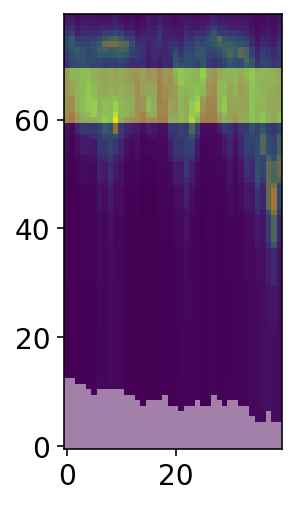

In [9]:
idx = 56
plt.imshow(AEM_sparse[:,start[0]:(start[0]+domain_size[0]),start[1]:(start[1]+domain_size[1])][:,:,idx],origin = 'lower')
plt.imshow(initial[:,:,idx]>0,origin = 'lower',alpha = 0.5)

# Velocity extension as perturbation in McMC

In [10]:
x = np.arange(domain_size[1])
y = np.arange(domain_size[0])
z = np.arange(AEM.shape[0])

In [11]:
initial[initial==0] = -1
model = skfmm.distance(initial)

In [12]:
data = AEM_sparse[:,start[0]:(start[0]+domain_size[0]),start[1]:(start[1]+domain_size[1])]

In [ ]:
# You can run multiple chains using this code block
import multiprocessing
iter_num = 5000
sigma = 140
anisotropy_ang = [0,180]
thalweg_small = thalweg[start[0]:(start[0]+domain_size[0]),start[1]:(start[1]+domain_size[1])]

input_list = [[model, data, thalweg_small, loss_function_1, loss_function_2, [10,20], [10,20], [5,20], anisotropy_ang, 1, sigma, iter_num, 6],
              [model, data, thalweg_small, loss_function_1, loss_function_2, [20,30], [20,30], [5,20], anisotropy_ang, 1, sigma, iter_num, 7],
              [model, data, thalweg_small, loss_function_1, loss_function_2, [10,20], [10,20], [10,20], anisotropy_ang, 1, sigma, iter_num, 8],
              [model, data, thalweg_small, loss_function_1, loss_function_2, [20,30], [20,30], [10,20], anisotropy_ang, 1, sigma, iter_num, 9],
              [model, data, thalweg_small, loss_function_1, loss_function_2, [10,20], [10,20], [20,40], anisotropy_ang, 1, sigma, iter_num, 10],
              [model, data, thalweg_small, loss_function_1, loss_function_2, [20,30], [20,30], [20,40], anisotropy_ang, 1, sigma, iter_num, 11]] 

# 6 runs
# the start indicate where we retrieve our velocity
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes = 6)
    result = pool.map(mp_non_stationary_implicit_3D,input_list)
    pool.close()

# MCMC simulations

In [159]:
loss_cache = np.load('../results/Case3_palaeovalley/5_loss_cache.npy') #3 is good, 5 is good

In [173]:
model_cache = np.load('../results/Case3_palaeovalley/5_model_cache.npy')

## Acceptance ratio

In [172]:
iter_num = 5000
start_ = 1500
1-np.sum(loss_cache[(start_+1):iter_num,0]-loss_cache[start_:(iter_num-1),0]==0)/(iter_num-start_-1)

0.43298085167190625

## Loss function

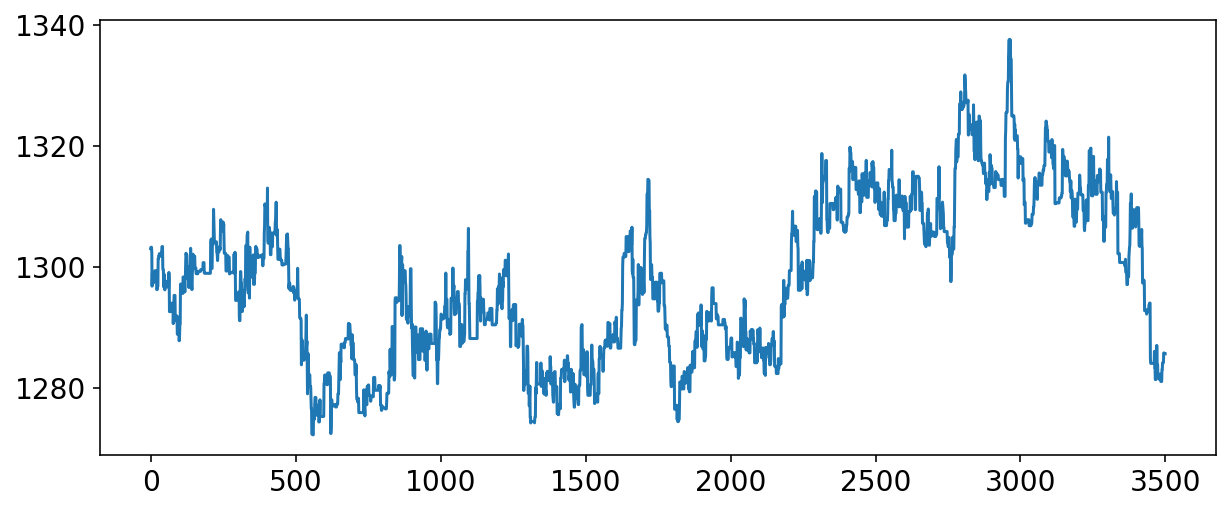

In [174]:
#plt.plot(10*loss_cache[:,1]+loss_cache[:,0])
plt.plot(loss_cache[1500:,0])
#plt.plot(10*loss_cache[:,1])

In [175]:
dis, depth, structure = loss_function_2((model_cache[-1,:,:,:]>0)*1,
                                        thalweg[start[0]:(start[0]+domain_size[0]),start[1]:(start[1]+domain_size[1])],
                                        more = True)

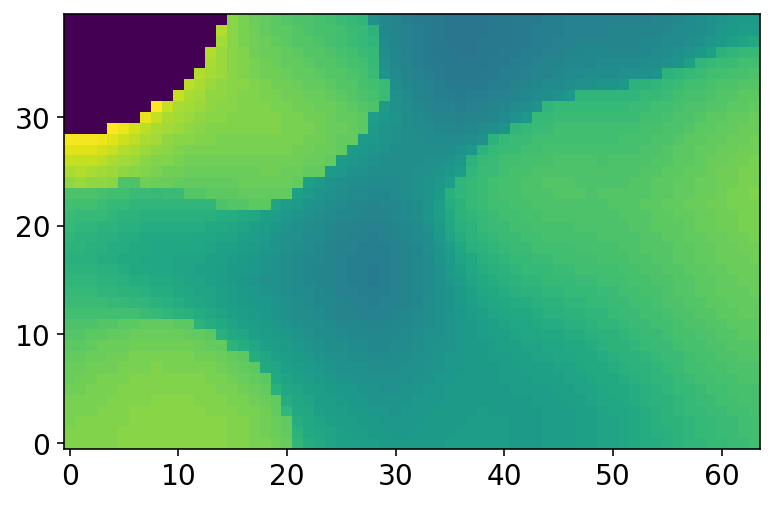

In [176]:
plt.imshow(depth,origin = 'lower')

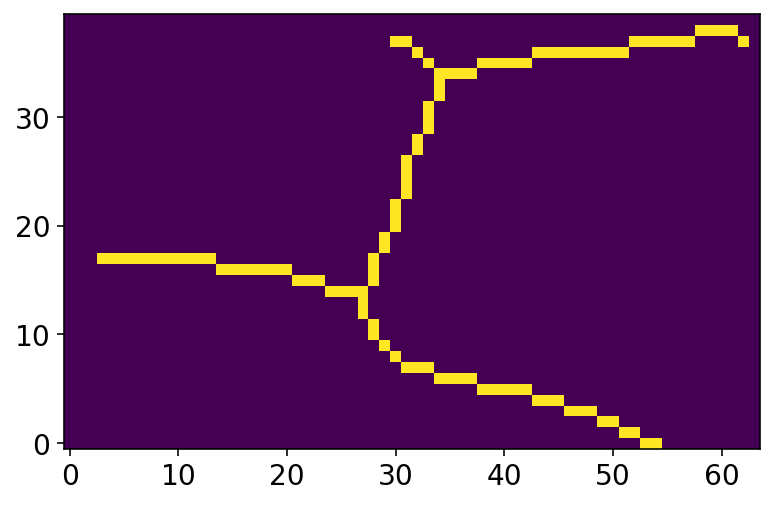

In [177]:
plt.imshow(structure,origin = 'lower')

## Visualization

In [178]:
AEM_sparse_small = AEM_sparse[:,start[0]:(start[0]+domain_size[0]),start[1]:(start[1]+domain_size[1])]

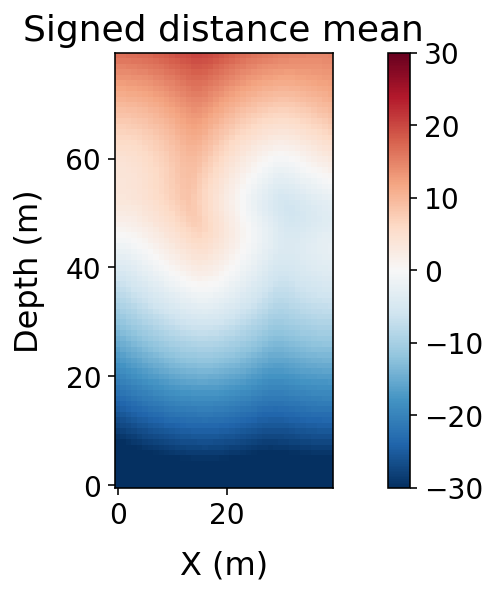

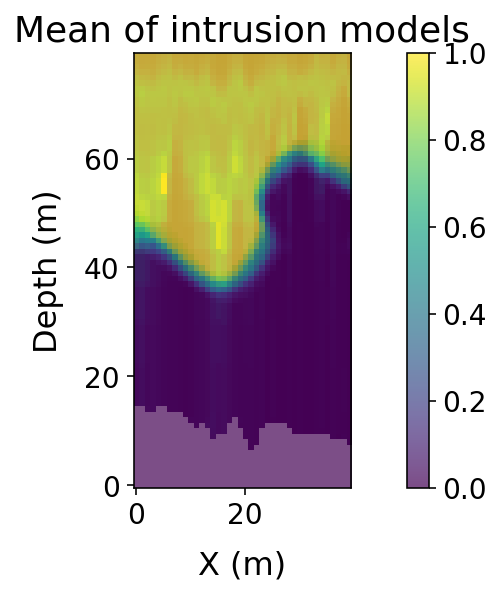

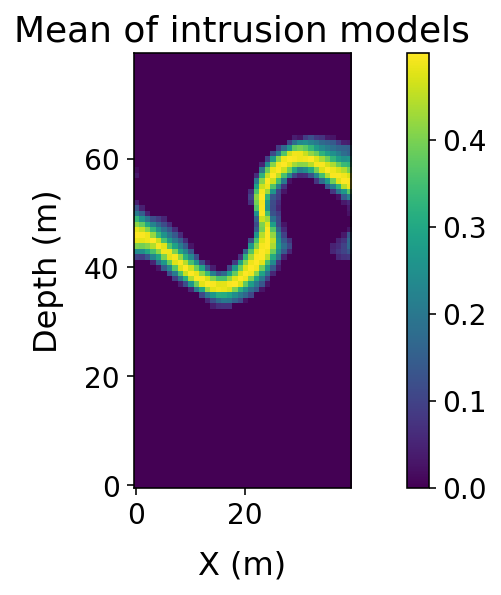

In [204]:
cut_off = 1500
slice_inline = 24

plt.imshow(np.mean(model_cache[cut_off:,:,:,slice_inline],axis = 0),vmin = -30,vmax =30,cmap = 'RdBu_r',origin = 'lower')
plt.colorbar()
plt.title('Signed distance mean')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()


plt.imshow(AEM_sparse_small[:,:,slice_inline],origin = 'lower')
plt.imshow(np.mean(model_cache[cut_off:,:,:,slice_inline]>0,axis = 0),origin = 'lower',alpha = 0.7)
plt.colorbar()
plt.title('Mean of palaeovalley models')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()


plt.imshow(AEM_sparse_small[:,:,slice_inline],origin = 'lower')
plt.imshow(np.std(model_cache[cut_off:,:,:,slice_inline]>0,axis = 0),origin = 'lower',alpha = 1)
plt.colorbar()
plt.title('Std of palaeovalley models')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

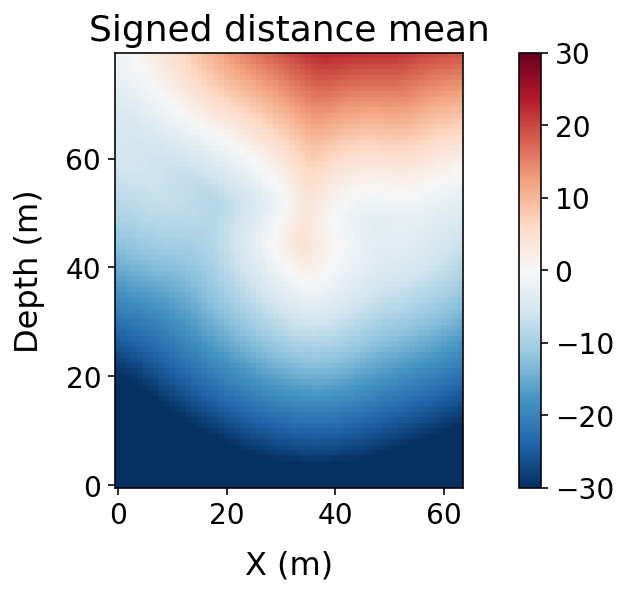

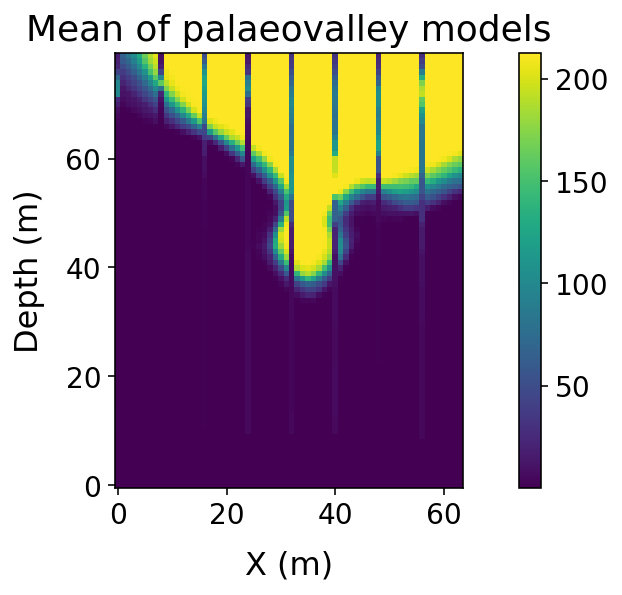

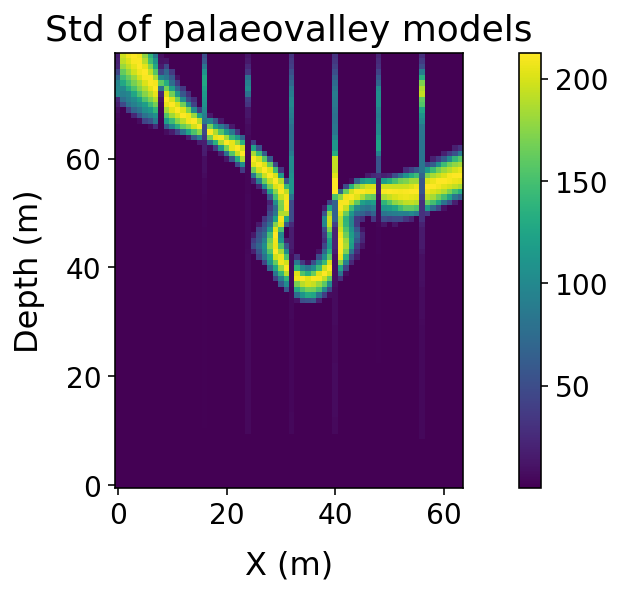

In [208]:
slice_inline = 0
slice_xline = 30
plt.imshow(np.mean(model_cache[cut_off:,:,slice_xline,:],axis = 0),vmin = -30,vmax =30,cmap = 'RdBu_r',origin = 'lower')
plt.colorbar()
plt.title('Signed distance mean')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

plt.imshow(np.mean(model_cache[cut_off:,:,slice_xline,:]>0,axis = 0),origin = 'lower')
plt.imshow(AEM_sparse_small[:,slice_xline,:],origin = 'lower')
plt.colorbar()
plt.title('Mean of palaeovalley models')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

plt.imshow(np.std(model_cache[cut_off:,:,slice_xline,:]>0,axis = 0),origin = 'lower')
plt.imshow(AEM_sparse_small[:,slice_xline,:],origin = 'lower')
plt.colorbar()
plt.title('Std of palaeovalley models')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

In [182]:
def Gelmen_Rubin_Diagnostic(chain1, chain2, burn_in = 10000,length = 20000):
    
    n = chain1[burn_in:burn_in+length].shape[0]
    
    W = (chain1[burn_in:burn_in+length].std()**2 + chain2[burn_in:burn_in+length].std()**2)/2
    mean1 = chain1[burn_in:burn_in+length].mean()
    mean2 = chain2[burn_in:burn_in+length].mean()
    mean = (mean1 + mean2)/2
    B = n * ((mean1 - mean)**2 + (mean2 - mean)**2)
    var_theta = (1 - 1/n) * W + 1/n*B
    
    return np.sqrt(var_theta/W)

In [183]:
iter_num = 5000
model_cache_mean = np.mean(model_cache.reshape(iter_num,-1),axis = 1)
model_cache_std = np.std(model_cache.reshape(iter_num,-1),axis = 1)

Text(0.5, 1.0, 'Trace plot')

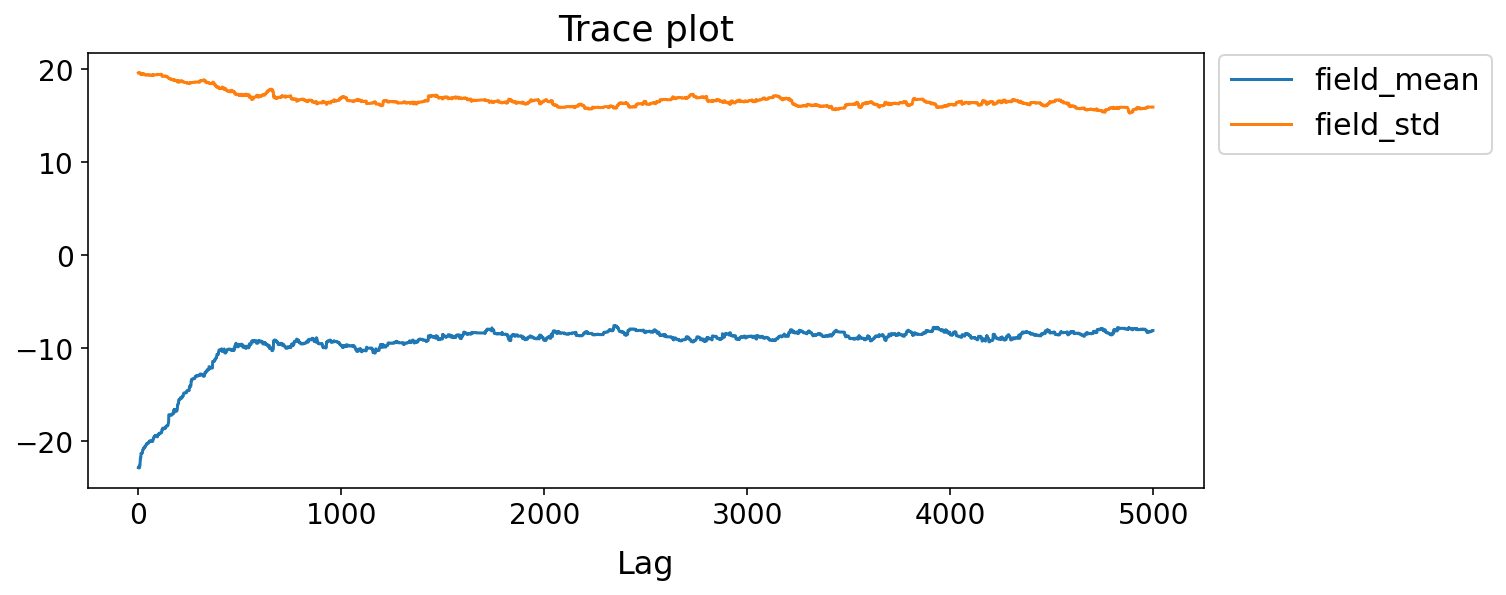

In [193]:
plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = (10, 4) 
plt.plot(model_cache_mean[:],label = 'field_mean')
plt.plot(model_cache_std[:],label = 'field_std')

plt.legend(bbox_to_anchor=(1., 1.03))
plt.xlabel('Lag')
plt.title('Trace plot')

In [191]:
Gelmen_Rubin_Diagnostic(model_cache_mean[2000:], model_cache_mean[4000:], burn_in = 0,length = 1000)

1.0237863990309026

In [190]:
Gelmen_Rubin_Diagnostic(model_cache_std[2000:], model_cache_std[4000:], burn_in = 0,length = 1000)

1.0997846651411214

## Visualization -- not working in Azure, good for local machine

In [9]:
import pyvista as pv
from pyvista import examples

In [10]:
def uniform_grid(matrix,var = False):
    matrix = np.swapaxes(matrix, axis1 = 0, axis2 = 2)

    grid = pv.UniformGrid()

    # Set the grid dimensions: shape + 1 because we want to inject our values on
    #   the CELL data
    grid.dimensions = np.array(matrix.shape) + 1

    # Edit the spatial reference
    grid.origin = (0,0,0)  # The bottom left corner of the data set
    grid.spacing = (250, 250, 100)  # These are the cell sizes along each axis

    # Add the data values to the cell data
    grid.cell_arrays["depth"] = matrix.flatten(order="F")  # Flatten the array!
    
    return grid
def grid_vis(model):
    color_array = np.array([np.arange(-158,1,2)]*40*64,dtype = 'float64').reshape(64,40,80)
    color_array = np.swapaxes(color_array, axis1 = 0, axis2 = 2)
    color_array[model<0] = -9999.
    grid = uniform_grid(color_array)
    grid = grid.threshold(-999.)
    return grid

In [11]:
import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

sh: 1: /usr/bin/Xvfb: not found


In [ ]:
grid = grid_vis(model[:,:,::-1])
plotter = pv.Plotter(off_screen=True)
plotter.add_mesh(grid, cmap = 'terrain_r',clim=[-90, 0])
plotter.camera_position = [0, 140, -230]
plotter.add_axes()
plotter.show()

In [ ]:
for i in tqdm(np.arange(0,5000,1000)):
    grid = grid_vis(model_cache[i,:,:,::-1])
    plotter = pv.Plotter(off_screen=True)
    plotter.add_mesh(grid, cmap = 'terrain_r',clim=[-90, 0])
    plotter.camera_position = [0, 140, -230]
    plotter.add_axes()
    plotter.save_graphic('../results/Case3_palaeovalley/valley_'+str(i).zfill(4)+'.png', title='', raster=True, painter=True)

In [ ]:
for i in tqdm(np.arange(0,6000,50)):
    grid = grid_vis(model_cache[i,:,:,::-1])
    plotter = pv.Plotter(off_screen=True)
    plotter.add_mesh(grid, cmap = 'terrain_r',clim=[-90, 0])
    plotter.camera_position = [0, 140, -230]
    plotter.add_axes()
    plotter.save_graphic('../Case3_palaeovalley/valley_'+str(i).zfill(4)+'.pdf', title='', raster=True, painter=True)

In [ ]:
import os
import imageio

png_dir = 'valley_result/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('movie.gif', images,fps=4)

In [ ]:
# grid.plot(show_grid=False, 
#           cpos=[0, 140, -230],
#           cmap = 'terrain_r',
#           clim=[-90, 0],
#           jupyter_backend='static',
#           screenshot = True) 